In [28]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from pprint import pprint

import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
from itertools import combinations
from collections import defaultdict
from collections import Counter

In [12]:
working_dir = os.getcwd()
train_news_file = os.path.join(working_dir, 'data','train','news.tsv')
train_behavior_file = os.path.join(working_dir, 'data','train','behaviors.tsv')
train_entity_embedding_file = os.path.join(working_dir, 'data','train','entity_embedding.vec')
train_triplets_file = os.path.join(working_dir, 'data','train','triplets.tsv')

val_news_file = os.path.join(working_dir, 'data','val','news.tsv')
val_behavior_file = os.path.join(working_dir, 'data','val','behaviors.tsv')
val_entity_embedding_file = os.path.join(working_dir, 'data','val','entity_embedding.vec')
val_triplets_file = os.path.join(working_dir, 'data','val','triplets.tsv')

In [13]:
# Load behaviors data (user-article interactions)
behaviors = pd.read_csv(train_behavior_file,
                       sep='\t',
                       header=None,
                       names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

behaviors = behaviors.dropna(subset=['user_id','history','impressions'])

# Process click history to get user-article pairs
user_article_pairs = []
for _, row in behaviors.iterrows():
    if pd.notna(row['history']):
        for article in row['history'].split():
            user_article_pairs.append((row['user_id'], article))

user_article_df = pd.DataFrame(user_article_pairs, columns=['user_id', 'article_id']).drop_duplicates()

# Load news data (article metadata)
news = pd.read_csv(train_news_file,
                  sep='\t',
                  header=None,
                  names=['article_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'])

# Create article-category relationships
article_category_df = news[['article_id', 'category', 'subcategory']].drop_duplicates()

In [14]:
import json

# Process entities from news data
entity_triples = []
for _, row in news.iterrows():
    # Parse title entities
    if pd.notna(row['title_entities']):
        entities = json.loads(row['title_entities'])
        for entity in entities:
            entity_triples.append((row['article_id'], 'HAS_ENTITY', entity['WikidataId']))
            entity_triples.append((entity['WikidataId'], 'IS_TYPE', entity['Type']))

    # Parse abstract entities (similar to above)

# Add these to your triples before training

In [15]:
# User-article triples
user_article_triples = [(user, 'CLICKS', article) for user, article in user_article_pairs]

# Article-category triples
article_category_triples = [(row['article_id'], 'BELONGS_TO', row['category'])
                           for _, row in article_category_df.iterrows()]

# Combine all triples
triples = user_article_triples + article_category_triples + entity_triples

# User-News Interaction Graph

In [16]:
user_article_G = nx.Graph()
user_article_G.add_edges_from(user_article_pairs)  # or similar for user-article-category, etc.

In [18]:
article_nodes = [(node, deg) for node, deg in user_article_G.degree if str(node).startswith('N')]

# Get top 5 articles
top_5_articles = sorted(article_nodes, key=lambda x: x[1], reverse=True)[:5]

for node, degree in top_5_articles:
    print(f"Article Node: {node}, Degree: {degree}")

Article Node: N306, Degree: 4747
Article Node: N42620, Degree: 3998
Article Node: N45794, Degree: 3283
Article Node: N31801, Degree: 3207
Article Node: N55189, Degree: 3045


In [19]:
top_article_ids = ['N306', 'N42620', 'N45794', 'N31801', 'N55189']
most_pop_articles = news[news['article_id'].isin(top_article_ids)]
most_pop_articles = most_pop_articles.set_index('article_id').loc[top_article_ids].reset_index()
most_pop_articles

,article_id,category,subcategory,title,abstract,url,title_entities,abstract_entities
0,N306,movies,movies-celebrity,Kevin Spacey Won't Be Charged in Sexual Assaul...,The Los Angeles County District Attorney's Off...,https://assets.msn.com/labs/mind/AAJy6rv.html,"[{""Label"": ""Kevin Spacey"", ""Type"": ""P"", ""Wikid...","[{""Label"": ""Kevin Spacey"", ""Type"": ""P"", ""Wikid..."
1,N42620,lifestyle,lifestylebuzz,Heidi Klum's 2019 Halloween Costume Transforma...,You might say she's scary good at playing dres...,https://assets.msn.com/labs/mind/AAJFlhi.html,"[{""Label"": ""Heidi Klum"", ""Type"": ""P"", ""Wikidat...","[{""Label"": ""Heidi Klum"", ""Type"": ""P"", ""Wikidat..."
2,N45794,news,newscrime,Four flight attendants were arrested in Miami'...,Four American Airlines flight attendants were ...,https://assets.msn.com/labs/mind/AAJcQKF.html,[],"[{""Label"": ""Miami International Airport"", ""Typ..."
3,N31801,news,newspolitics,Joe Biden reportedly denied Communion at a Sou...,Joe Biden has a complicated history with the C...,https://assets.msn.com/labs/mind/AAJwml6.html,"[{""Label"": ""Joe Biden"", ""Type"": ""P"", ""Wikidata...","[{""Label"": ""Catholic Church"", ""Type"": ""O"", ""Wi..."
4,N55189,tv,tvnews,"'Wheel Of Fortune' Guest Delivers Hilarious, O...","We'd like to solve the puzzle, Pat: Blair Davi...",https://assets.msn.com/labs/mind/AAIORni.html,[],"[{""Label"": ""Pat Sajak"", ""Type"": ""P"", ""Wikidata..."


# User to User Communities

In [67]:
user_click_counts = Counter()

user_article_triples = pd.DataFrame(user_article_triples).drop_duplicates().values.tolist()

for user_id, relation, article_id in user_article_triples:
    user_click_counts[user_id] += 1
        
top_25_users1 = set([user for user, count in user_click_counts.most_common(25)])

filtered_triples = []
for user_id, relation, article_id in triples:
    if user_id in top_25_users and relation == "CLICKS":
        filtered_triples.append((user_id, relation, article_id))

In [69]:
len(user_to_articles['U27166'])

0

In [68]:
user_to_articles = defaultdict(set)

for user_id, _, article_id in filtered_triples:
    user_to_articles[user_id].add(article_id)

G_user = nx.Graph()

G_user.add_nodes_from(top_25_users)

# For loop AI generated
for users in user_to_articles.values():
    if users
    users = list(users)
    for i in range(len(users)):
        for j in range(i + 1, len(users)):
            user_i = users[i]
            user_j = users[j]
            if G_user.has_edge(user_i, user_j):
                G_user[user_i][user_j]['weight'] += 1  # Increase weight if they share multiple articles
            else:
                G_user.add_edge(user_i, user_j, weight=1)

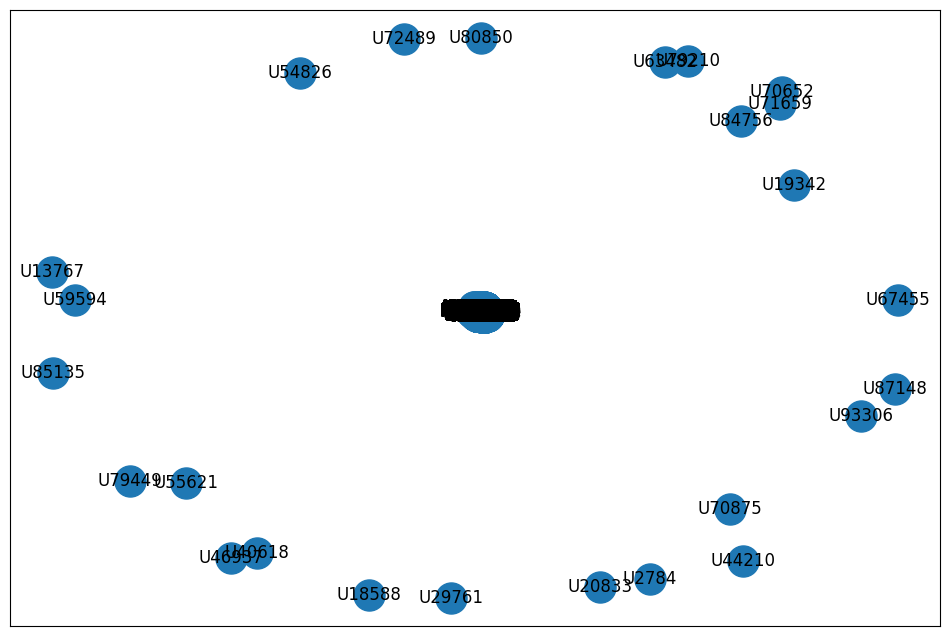

In [71]:
# Visualization AI Generated
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_user, seed=256)
nx.draw_networkx_nodes(G_user, pos, node_size=500)
nx.draw_networkx_edges(G_user, pos, width=10)
nx.draw_networkx_labels(G_user, pos, font_size=12, font_family="sans-serif")
plt.axis('on')
plt.show()

In [74]:
len(list(G_user.edges))

1292079

In [77]:
len(list(G_user.nodes))

4944

In [72]:
communities = list(nx.community.girvan_newman(G_user))

KeyboardInterrupt: 

In [42]:
import itertools
# Step 4: Check overlaps between users
overlapping_pairs = []

for user1, user2 in itertools.combinations(top_25_users, 2):
    if user_to_articles[user1] & user_to_articles[user2]:  # set intersection
        overlapping_pairs.append((user1, user2))

# Step 5: Summarize
users_in_overlap = set()
for u1, u2 in overlapping_pairs:
    users_in_overlap.add(u1)
    users_in_overlap.add(u2)

print(f"Number of top 25 users who share at least one article with someone else: {len(users_in_overlap)}")
print(f"Total overlapping user pairs: {len(overlapping_pairs)}")

Number of top 25 users who share at least one article with someone else: 25
Total overlapping user pairs: 300


In [47]:
user_to_articles.keys()

dict_keys(['U32146', 'U67455', 'U51286', 'U83337', 'U72280', 'U54826', 'U63482', 'U93306', 'U8561', 'U79449', 'U44210', 'U20833', 'U26994', 'U79210', 'U72489', 'U27166', 'U84756', 'U59594', 'U17204', 'U44201', 'U85878', 'U42382', 'U55621', 'U69965', 'U81564'])